<a href="https://colab.research.google.com/github/ahmadalideeb/machine-learning/blob/master/PK2/MMO_PK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Цель работы
Классификация текстов на арабском языке с использованием разных видов классификаторов нормальных и наивных байесовских классификаторов.

#Набор данных
Набор данных представляет собой коллекцию арабских текстов, которая охватывает твит арабских людей в Twitter.

Набор данных состоит из 9694 твитов и 246 872 слов, структурированных в текстовые файлы.

Документы в наборе данных делятся на 4 класса: объективные, положительные, отрицательные, нейтральные.

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        temp_f1=f1_score(temp_data_flt['t'].values, 
            temp_data_flt['p'].values,average='weighted')
        # сохранение результата в словарь
        res[c] = (temp_acc,temp_f1)
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t \t  Accuracy \t \t \t f1_score')
    for i in accs:
        if i != 'NEUTRAL':
          print('{} \t \t {} \t \t {}'.format(i, accs[i][0],accs[i][1]))
        else:
          print('NEUT \t \t {} \t \t {}'.format(accs[i][0],accs[i][1]))

In [3]:
# Загрузка данных
data = pd.read_csv('/content/gdrive/My Drive/Tweets.txt', delimiter='\t',header=None, names=['text', 'target'], error_bad_lines=False)
data.head()

,text,target
0,بعد استقالة رئيس #المحكمة_الدستورية ننتظر استق...,OBJ
1,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...,POS
2,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...,NEG
3,#الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية ...,OBJ
4,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...,NEUTRAL


Количество строки в нашем наборе данных:

In [4]:
data.shape

(9694, 2)

In [5]:
data.count()

text      9694
target    9694
dtype: int64

In [6]:
data.target.value_counts()

OBJ        6470
NEG        1642
NEUTRAL     805
POS         777
Name: target, dtype: int64

In [7]:
data.head()

,text,target
0,بعد استقالة رئيس #المحكمة_الدستورية ننتظر استق...,OBJ
1,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...,POS
2,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...,NEG
3,#الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية ...,OBJ
4,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...,NEUTRAL


In [8]:
# Сформируем общий словарь для обучения моделей из обучающей и тестовой выборки
vocab_list = data['text'].tolist()
vocab_list[1:10]

['أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر، بمناسبة صدور أولى روايته',
 'البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام العريان الي واشنطن شئ مقرف',
 '#الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية أول فيلم استقصائي يتناول أسرار و كواليس تعرض لأول مرة حول حقيقة',
 'الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقولها ملل الله وكيلك تعطيني محاضرة عن الفسق والفجور بجنوب الشيشان #ليه كذا يانبع الحنان',
 '#انتخبوا_العرص #انتخبوا_البرص #مرسى_رئيسى #اين_رئيسى #_ #__ö',
 'امير عيد هو اللي فعلا يتقال عليه ستريكر صريح #كاريوكي #السكة_شمال',
 'أحكي لكم قصة حدثت بين شاب و أحد الفتيات كان بينهم حب كبير ولكن حدثت غلطة واحدة؟ فهل ستستمر هذه القصة ويتم',
 'أدعوكم لحضور الندوة الثقافية الأربعاء مركز اعداد القادة التفاصيل',
 'عودة جماعة الإخوان إلى الحياة السياسية بنفس وضعها السابق مستحيلة والطرمخة على جرائم الماضي لن تجعلنا نتقدم شبرا']

Количество уникальных слов в наборе данных.

In [9]:
vocabVect = CountVectorizer()
vocabVect.fit(vocab_list)
corpusVocab = vocabVect.vocabulary_
print('Количество сформированных признаков - {}'.format(len(corpusVocab)))

Количество сформированных признаков - 37561


Примеры некоторых слов, взятых из набора данных с их частотами.

In [10]:
for i in list(corpusVocab)[1:10]:
    print('{}={}'.format(i, corpusVocab[i]))

استقالة=3491
رئيس=18456
المحكمة_الدستورية=9298
ننتظر=30067
رئيس_القضاء=18457
السودان=7272
أهنئ=1942
الدكتور=6675
أحمد=977


In [0]:
test_features = vocabVect.transform(vocab_list)

In [12]:
vocabVect.get_feature_names()[100:120]

['14آذار',
 '15',
 '150',
 '151',
 '1515',
 '153',
 '1540',
 '155',
 '157',
 '15سنة',
 '15على',
 '16',
 '1615445',
 '1620995',
 '168',
 '16طالبا',
 '17',
 '172',
 '173',
 '1735']

In [13]:
ncv = CountVectorizer(ngram_range=(1,3))
ngram_features = ncv.fit_transform(vocab_list)
ngram_features

<9694x246872 sparse matrix of type '<class 'numpy.int64'>'
	with 369945 stored elements in Compressed Sparse Row format>

In [14]:
len(ncv.get_feature_names())

246872

In [15]:
# Теперь признаками являются N-граммы
ncv.get_feature_names()[1:30]

['00 00',
 '00 00 الاجتماع',
 '00 00 للإستفسار',
 '00 10',
 '00 10 00',
 '00 11',
 '00 11 00',
 '00 12',
 '00 12 00',
 '00 22',
 '00 22 00',
 '00 الاجتماع',
 '00 الاجتماع الأول',
 '00 القناة',
 '00 القناة عصام',
 '00 المنسق',
 '00 المنسق كريم',
 '00 بتوقيت',
 '00 بتوقيت القاهرة',
 '00 عصرا',
 '00 عصرا مع',
 '00 للإستفسار',
 '00 للإستفسار والتواصل',
 '00 مساء',
 '00 مساء على',
 '00 يتشرف',
 '00 يتشرف الدكتور',
 '000',
 '000 000']

In [16]:
tfidfv = TfidfVectorizer(ngram_range=(1,3))
tfidf_ngram_features = tfidfv.fit_transform(vocab_list)
tfidf_ngram_features

<9694x246872 sparse matrix of type '<class 'numpy.float64'>'
	with 369945 stored elements in Compressed Sparse Row format>

#Подгонка и прогнозирование данных обучения и испытаний с использованием нескольких векторизаторов и классификаторов

In [0]:
def VectorizeAndClassify(vectorizers_list, classifiers_list):
    for v in vectorizers_list:
        for c in classifiers_list:
            pipeline1 = Pipeline([("vectorizer", v), ("classifier", c)])
            score = cross_val_score(pipeline1, data['text'], data['target'], scoring='accuracy', cv=3).mean()
            score2=cross_val_score(pipeline1, data['text'], data['target'], scoring='f1_weighted', cv=3).mean()
            print('Векторизация - {}'.format(v))
            print('Модель для классификации - {}'.format(c))
            print('Accuracy = {}'.format(score))
            print('F1 = {}'.format(score2))
            print('===========================')

In [18]:
vectorizers_list = [CountVectorizer(vocabulary = corpusVocab), TfidfVectorizer(vocabulary = corpusVocab)]
classifiers_list = [LogisticRegression(C=3.0), LinearSVC(), KNeighborsClassifier()]
VectorizeAndClassify(vectorizers_list, classifiers_list)

Векторизация - CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None,
                vocabulary={'00': 0, '000': 1, '00202': 2, '005': 3, '009': 4,
                            '01': 5, '01001135875': 6, '01002118193': 7,
                            '01008880090': 8, '0101004800': 9, '0103424388': 10,
                            '0105064942': 11, '01069883354': 12,
                            '0107381486': 13, '0109333999': 14, '011': 15,
                            '0111650008': 16, '0112': 17, '01201968': 18,
                            '01280423836': 19, '01289954776': 20, '0155': 21,
                            '0165541351': 22, '0190555044': 23

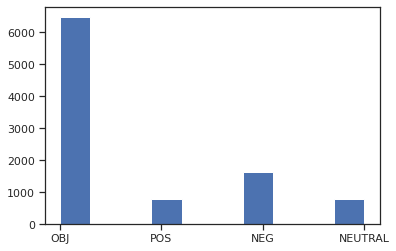

In [19]:
plt.hist(data['target'])
plt.show()

Мы собираемся разделить наши данные между данными обучения и тестирования в пропорции 0,7.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.3, random_state=1)

In [0]:
def sentiment(v, c):
    model = Pipeline(
        [("vectorizer", v), 
         ("classifier", c)])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_accuracy_score_for_classes(y_test, y_pred)
    labels=['NEG', 'NEUTRAL', 'OBJ', 'POS']
    plot_confusion_matrix(model,X_test, y_test,display_labels=['NEG', 'NEUTRAL', 'OBJ', 'POS'],normalize='true',cmap=plt.cm.Blues)

##Использование Tfid Vectorizer и логистической регрессии

Метка 	 	  Accuracy 	 	 	 f1_score
NEG 	 	 0.24329896907216494 	 	 0.3913764510779436
NEUT 	 	 0.04888888888888889 	 	 0.09322033898305083
OBJ 	 	 0.9449021627188465 	 	 0.9716706380725444
POS 	 	 0.10894941634241245 	 	 0.19649122807017544


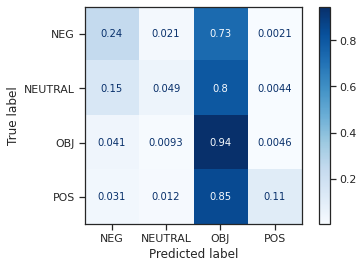

In [22]:
sentiment(TfidfVectorizer(), LogisticRegression(C=3.0))

Метка 	 	  Accuracy 	 	 	 f1_score
NEG 	 	 0.24536082474226803 	 	 0.3940397350993377
NEUT 	 	 0.035555555555555556 	 	 0.06866952789699571
OBJ 	 	 0.9490216271884655 	 	 0.9738441215323645
POS 	 	 0.06614785992217899 	 	 0.12408759124087591


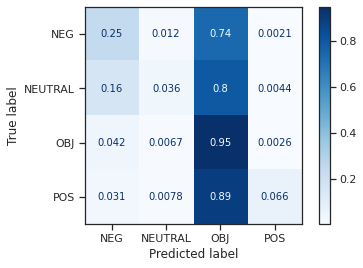

In [23]:
sentiment(TfidfVectorizer(ngram_range=(1,3)), LogisticRegression(C=3.0))

Метка 	 	  Accuracy 	 	 	 f1_score
NEG 	 	 0.23505154639175257 	 	 0.3806343906510851
NEUT 	 	 0.044444444444444446 	 	 0.08510638297872339
OBJ 	 	 0.9485066941297632 	 	 0.9735729386892178
POS 	 	 0.07392996108949416 	 	 0.13768115942028986


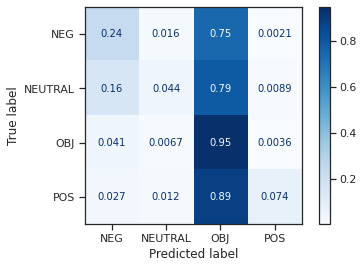

In [24]:
sentiment(TfidfVectorizer(ngram_range=(1,2)), LogisticRegression(C=3.0))

Метка 	 	  Accuracy 	 	 	 f1_score
NEG 	 	 0.23711340206185566 	 	 0.3833333333333333
NEUT 	 	 0.035555555555555556 	 	 0.06866952789699571
OBJ 	 	 0.9521112255406797 	 	 0.9754682141915062
POS 	 	 0.058365758754863814 	 	 0.11029411764705882


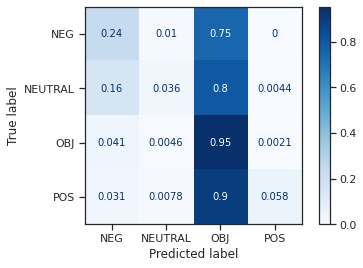

In [25]:
sentiment(TfidfVectorizer(ngram_range=(1,4)), LogisticRegression(C=3.0))

Метка 	 	  Accuracy 	 	 	 f1_score
NEG 	 	 0.030927835051546393 	 	 0.06000000000000001
NEUT 	 	 0.013333333333333334 	 	 0.02631578947368421
OBJ 	 	 0.9969104016477858 	 	 0.9984528107271788
POS 	 	 0.0038910505836575876 	 	 0.007751937984496124


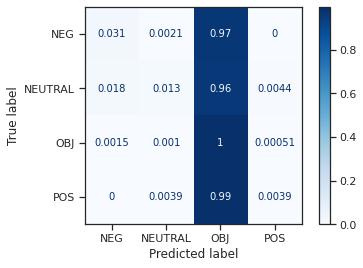

In [26]:
sentiment(TfidfVectorizer(ngram_range=(2,4)), LogisticRegression(C=3.0))

##Использование Tfid Vectorizer и полиномиального наивного байесовского

Метка 	 	  Accuracy 	 	 	 f1_score
NEG 	 	 0.0 	 	 0.0
NEUT 	 	 0.0 	 	 0.0
OBJ 	 	 1.0 	 	 1.0
POS 	 	 0.0 	 	 0.0


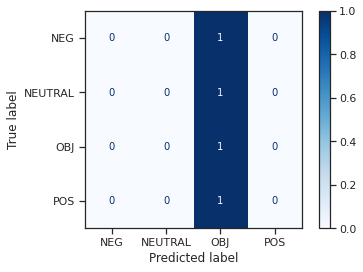

In [27]:
sentiment(TfidfVectorizer(ngram_range=(1,2)), MultinomialNB())

##Использование Tfid Vectorizer и наивного байесовского Бернулли

Метка 	 	  Accuracy 	 	 	 f1_score
NEG 	 	 0.002061855670103093 	 	 0.00411522633744856
NEUT 	 	 0.0 	 	 0.0
OBJ 	 	 0.9984552008238929 	 	 0.9992270033496522
POS 	 	 0.0 	 	 0.0


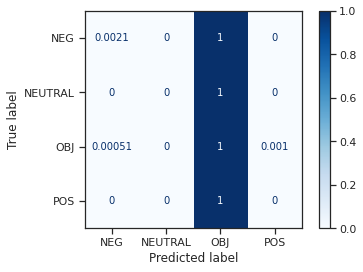

In [28]:
sentiment(TfidfVectorizer(ngram_range=(1,2)), BernoulliNB())

##Использование Tfid Vectorizer и дополнения наивного байесовского

Метка 	 	  Accuracy 	 	 	 f1_score
NEG 	 	 0.1134020618556701 	 	 0.2037037037037037
NEUT 	 	 0.044444444444444446 	 	 0.08510638297872339
OBJ 	 	 0.9598352214212152 	 	 0.9795060430898582
POS 	 	 0.07003891050583658 	 	 0.13090909090909092


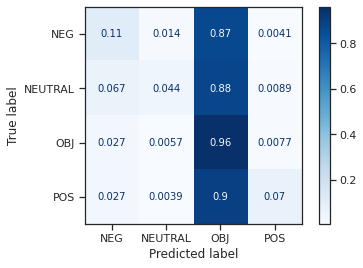

In [29]:
sentiment(TfidfVectorizer(ngram_range=(1,2)), ComplementNB())

#Вывод
Мы видим, что лучшим классификатором при работе с данными был LogisticRegression, потому что это было более подходящим для классификации всех различных типов классов.
Но мы можем заметить, что у всех классификаторов была проблема с классификацией текста из классов (положительный, отрицательный, нейтральный), и причина этого заключается в отсутствии информации из тех классов, где 66% из твитов классифицируются как объективные и 33% принадлежат в оставшиеся три класса.
Таким образом, классификатор всегда склонен обнаруживать объективный класс.